# Prophet Python Baseline

In [423]:
# load packages
import pandas as pd
import numpy as np
from fbprophet import Prophet
import os

import warnings

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

# Necessary functions

In [89]:
# custom MAPE
def mape(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred) / y_true)) * 100

# custom MAE
def mae(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.nanmean(np.abs((y_true - y_pred)))

In [8]:
def run_prophet(series, timeframe=timeframe):
    """
    Runs the Prophet 
    
    Key arguments:
    --------------
    series -- (DataFrame) time series data
    timeframe -- (DataFrame) a DataFrame with one column 
                 consisting of predicted dates

    Returns: 
    --------------
    Returns the forecast of the predictions 

    """
    model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False, 
                    # changepoint_prior_scale=0.001,
                    # mcmc_samples=300,
                    interval_width=0.95)
    model.fit(series)
    forecast = model.predict(timeframe)
    return forecast, model

In [9]:
def aggregate_error(data, variable=None, method="mape"):
    """
    Given the combined data from our generated forecast and
    returns the aggregated error
    
    Key arguments:
    --------------
    data -- (dict) dictionary of data that we want to use
    variable -- (str) variable name
    method -- (str) mape or mae

    Returns: 
    --------------
    The aggregated MAPE or MAE of the forecast

    """
    test_pred = timeframe.copy()
    test_true = timeframe.copy()
    if variable is None:
        for i in data:
            test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
            test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    else:
        for i in data:
            if variable in i:
                test_pred = pd.merge(test_pred, data[i][["ds", "yhat"]], on="ds")
                test_true = pd.merge(test_true, data[i][["ds", "y"]], on="ds")
    sum_pred = test_pred.sum(axis=1)
    sum_true = test_true.sum(axis=1)
    if method == "mape":
        return mape(sum_true, sum_pred)
    if method == "mae":
        return mae(sum_true, sum_pred)

In [90]:
# read data
raw_data = pd.read_csv("../data/train.csv", parse_dates=["SHIFT_DATE"])

In [91]:
# split data to train and val
train = raw_data[(raw_data["SHIFT_DATE"]>"2012-12-31") & (raw_data["SHIFT_DATE"]<"2017-01-01")]
val = raw_data[(raw_data["SHIFT_DATE"]>"2016-12-31") & (raw_data["SHIFT_DATE"]<"2018-01-01")]

# Split by Job Family and Site

In [310]:
# using only a portion of the sites
small_train = train[(train["SITE"]=="St Paul's Hospital") |
                    (train["SITE"]=="Mt St Joseph") |
                    (train["SITE"]=="Holy Family") |
                    (train["SITE"]=="SVH Langara") |
                    (train["SITE"]=="Brock Fahrni") |
                    (train["SITE"]=="Youville Residence")]
small_train = small_train[(small_train["JOB_FAMILY"]=="DC1000") |
                    (small_train["JOB_FAMILY"]=="DC2A00") |
                    (small_train["JOB_FAMILY"]=="DC2B00") ]

small_val = val[(val["SITE"]=="St Paul's Hospital") |
                (val["SITE"]=="Mt St Joseph") |
                (val["SITE"]=="Holy Family") |
                (val["SITE"]=="SVH Langara") |
                (val["SITE"]=="Brock Fahrni") |
                (val["SITE"]=="Youville Residence")]
small_val = small_val[(small_val["JOB_FAMILY"]=="DC1000") |
                    (small_val["JOB_FAMILY"]=="DC2A00") |
                    (small_val["JOB_FAMILY"]=="DC2B00") ]

In [473]:
# create training dataframes
splitting_train = small_train.groupby(["JOB_FAMILY", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_train = splitting_train.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val = small_val.groupby(["JOB_FAMILY", "SITE", "SHIFT_DATE"]).size().reset_index()
splitting_val = splitting_val.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [474]:
# create timeframe data for prediction
total_timeframe = pd.DataFrame(pd.date_range(start='2013-01-01', end='2016-12-31', freq="D")).rename({0:"ds"}, axis=1)
timeframe = pd.DataFrame(pd.date_range(start='2017-01-01', end='2017-12-31', freq="D")).rename({0:"ds"}, axis=1)

In [475]:
small_sites = small_train["SITE"].unique()
small_jfs = small_train["JOB_FAMILY"].unique()

In [367]:
warnings.simplefilter('ignore')
# create and store predictions and true results
models = {}
split_data = {}
pred_results_past = {}
pred_results_future = {}
true_results = {}
for i in small_sites:
    for j in small_jfs:
        temp_data_train = splitting_train[(splitting_train["SITE"]==i) & (splitting_train["JOB_FAMILY"]==j)].reset_index()
        temp_data_train = pd.merge(total_timeframe, temp_data_train, on="ds", how="outer")
        temp_data_train["y"] = temp_data_train["y"].fillna(0)
        
        temp_data_val = splitting_val[(splitting_val["SITE"]==i) & (splitting_val["JOB_FAMILY"]==j)].reset_index(drop=True)
        temp_data_val = pd.merge(timeframe, temp_data_val, on="ds", how="outer")
        temp_data_val["y"] = temp_data_val["y"].fillna(0)
        
        split_data[(i, j)] = temp_data_train
        true_results[(i, j)] = temp_data_val
        pred_results_past[(i, j)], models[(i,j)] = run_prophet(temp_data_train, total_timeframe)
        pred_results_future[(i, j)] = models[(i,j)].predict(timeframe)
        print("Fitting -", i, j, ": Done")

Fitting - St Paul's Hospital DC1000 : Done
Fitting - St Paul's Hospital DC2B00 : Done
Fitting - St Paul's Hospital DC2A00 : Done
Fitting - SVH Langara DC1000 : Done
Fitting - SVH Langara DC2B00 : Done
Fitting - SVH Langara DC2A00 : Done
Fitting - Mt St Joseph DC1000 : Done
Fitting - Mt St Joseph DC2B00 : Done
Fitting - Mt St Joseph DC2A00 : Done
Fitting - Brock Fahrni DC1000 : Done
Fitting - Brock Fahrni DC2B00 : Done
Fitting - Brock Fahrni DC2A00 : Done
Fitting - Holy Family DC1000 : Done
Fitting - Holy Family DC2B00 : Done
Fitting - Holy Family DC2A00 : Done
Fitting - Youville Residence DC1000 : Done
Fitting - Youville Residence DC2B00 : Done
Fitting - Youville Residence DC2A00 : Done


## Get weekly errors

In [369]:
# combine predictions and true results
combined = {}
for i in true_results:
    if pred_results_future[i] is not None:
        combined[i] = pd.merge(true_results[i], 
                               pred_results_future[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

In [391]:
# convert to week and calculating errors weekly
weekly = {}
for i in combined:
    # create week column
    combined[i]["ds"] = combined[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    combined[i]["week"] = combined[i]["ds"].dt.week

    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined[i].groupby("ds").yhat.sum().round(0).astype(int).reset_index()
    weekly_yhat_lower = combined[i].groupby("ds").yhat_lower.sum().round(0).astype(int).reset_index()
    weekly_yhat_upper = combined[i].groupby("ds").yhat_upper.sum().round(0).astype(int).reset_index()

    # replace negative prediction values with 0
    weekly_yhat = weekly_yhat.where(weekly_yhat["yhat"] >= 0, 0)
    weekly_yhat_lower = weekly_yhat_lower.where(weekly_yhat_lower["yhat_lower"] >= 0, 0)
    weekly_yhat_upper = weekly_yhat_upper.where(weekly_yhat_upper["yhat_upper"] >= 0, 0)


    # merge weekly results
    weekly[i] = pd.concat([weekly_y, weekly_yhat["yhat"],
                           weekly_yhat_lower["yhat_lower"],
                           weekly_yhat_upper["yhat_upper"]],
                          axis=1)

    # create columns "year", "site", "JOB_FAMILY"
    length = weekly[i].shape[0]
    weekly[i]["week"] = weekly[i]["ds"].dt.weekofyear
    weekly[i]["site"] = np.repeat(i[0], length)
    weekly[i]["job_family"] = np.repeat(i[1], length)

In [392]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'DC1000'): MAPE: 5.164288029331788, MAE: 100.64150943396227
("St Paul's Hospital", 'DC2B00'): MAPE: 24.20941722668481, MAE: 18.264150943396228
("St Paul's Hospital", 'DC2A00'): MAPE: 32.5758445361709, MAE: 38.43396226415094
('SVH Langara', 'DC1000'): MAPE: 20.49649722444216, MAE: 9.566037735849056
('SVH Langara', 'DC2B00'): MAPE: inf, MAE: 1.1886792452830188
('SVH Langara', 'DC2A00'): MAPE: inf, MAE: 4.90566037735849
('Mt St Joseph', 'DC1000'): MAPE: 13.093594261071328, MAE: 38.24528301886792
('Mt St Joseph', 'DC2B00'): MAPE: inf, MAE: 5.773584905660377
('Mt St Joseph', 'DC2A00'): MAPE: 48.20761297529101, MAE: 8.49056603773585
('Brock Fahrni', 'DC1000'): MAPE: 23.184243084027305, MAE: 6.113207547169812
('Brock Fahrni', 'DC2B00'): MAPE: inf, MAE: 1.5660377358490567
('Brock Fahrni', 'DC2A00'): MAPE: inf, MAE: 3.207547169811321
('Holy Family', 'DC1000'): MAPE: 22.249402953360526, MAE: 14.50943396226415
('Holy Family', 'DC2B00'): MAPE: inf, MAE: 1.490566037735849
('H

In [393]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 4.423017859986734, MAE: 102.45098039215686
SVH Langara: MAPE: 23.296665910173868, MAE: 11.490196078431373
Mt St Joseph: MAPE: 11.84669914863889, MAE: 44.01960784313726
Brock Fahrni: MAPE: 20.23465861811913, MAE: 8.764705882352942
Holy Family: MAPE: 21.68574371053305, MAE: 15.882352941176471
Youville Residence: MAPE: 17.385198412413555, MAE: 8.137254901960784


In [394]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

DC1000: MAPE: 4.590198853601259, MAE: 121.2156862745098
DC2B00: MAPE: 15.27281900170738, MAE: 18.901960784313726
DC2A00: MAPE: 30.380039840599736, MAE: 47.92156862745098


In [395]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 4.528495118505118
Total MAE: 130.7058823529412


# Minimize error


In [396]:
from stldecompose import decompose, forecast
from stldecompose.forecast_funcs import (naive,
                                         drift, 
                                         mean, 
                                         seasonal_naive)


In [397]:
for i in weekly:
    forecasted = pred_results_past[i]
    actual = split_data[i]

    error = actual["y"] - forecasted["yhat"]
    obs = total_timeframe.copy()
    obs["error"] = error
    obs = obs.set_index("ds")

    decomp = decompose(obs, period=365)
    weekly_fcast = forecast(decomp, steps=365, fc_func=drift, seasonal=True)
    weekly_fcast["week"] = weekly_fcast.index-pd.DateOffset(weekday=0, weeks=1)
    weekly_fcast = weekly_fcast.groupby("week").sum()

    resid_fcast = weekly_fcast.reset_index()["drift+seasonal"]
    weekly_yhat = (weekly[i]["yhat"] + resid_fcast).round(0)
    weekly_yhat_lower = (weekly[i]["yhat_lower"] + resid_fcast).round(0)
    weekly_yhat_upper = (weekly[i]["yhat_upper"] + resid_fcast).round(0)

    weekly[i]["yhat"] = weekly_yhat.where(weekly_yhat >= 0, 0)
    weekly[i]["yhat_lower"] = weekly_yhat_lower.where(weekly_yhat_lower >= 0, 0)
    weekly[i]["yhat_upper"] = weekly_yhat_upper.where(weekly_yhat_upper >= 0, 0)

# Print new errors

In [398]:
for i in weekly:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly[i]["y"], weekly[i]["yhat"]), 
                                         mae(weekly[i]["y"], weekly[i]["yhat"])))

("St Paul's Hospital", 'DC1000'): MAPE: 4.206521926903699, MAE: 78.66037735849056
("St Paul's Hospital", 'DC2B00'): MAPE: 29.085851953243473, MAE: 18.471698113207548
("St Paul's Hospital", 'DC2A00'): MAPE: 32.95885190233128, MAE: 38.58490566037736
('SVH Langara', 'DC1000'): MAPE: 20.661273582965272, MAE: 10.226415094339623
('SVH Langara', 'DC2B00'): MAPE: inf, MAE: 1.3018867924528301
('SVH Langara', 'DC2A00'): MAPE: inf, MAE: 4.30188679245283
('Mt St Joseph', 'DC1000'): MAPE: 14.51027917462437, MAE: 39.886792452830186
('Mt St Joseph', 'DC2B00'): MAPE: inf, MAE: 5.60377358490566
('Mt St Joseph', 'DC2A00'): MAPE: 46.548349510007085, MAE: 8.377358490566039
('Brock Fahrni', 'DC1000'): MAPE: 24.41204540574981, MAE: 6.7924528301886795
('Brock Fahrni', 'DC2B00'): MAPE: inf, MAE: 1.5471698113207548
('Brock Fahrni', 'DC2A00'): MAPE: inf, MAE: 3.3773584905660377
('Holy Family', 'DC1000'): MAPE: 23.99801041594299, MAE: 15.849056603773585
('Holy Family', 'DC2B00'): MAPE: inf, MAE: 1.66037735849056

In [399]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

St Paul's Hospital: MAPE: 3.6638116597630193, MAE: 84.13725490196079
SVH Langara: MAPE: 19.182267344843986, MAE: 10.235294117647058
Mt St Joseph: MAPE: 12.179255296743037, MAE: 45.84313725490196
Brock Fahrni: MAPE: 21.473827195514247, MAE: 9.372549019607844
Holy Family: MAPE: 22.911476241893762, MAE: 17.96078431372549
Youville Residence: MAPE: 21.351446374800137, MAE: 10.647058823529411


In [400]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly, i, "mape"), aggregate_error(weekly, i, "mae")))

DC1000: MAPE: 3.885015236573383, MAE: 101.52941176470588
DC2B00: MAPE: 16.018114090632483, MAE: 19.745098039215687
DC2A00: MAPE: 27.283468241081977, MAE: 43.23529411764706


In [401]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly, method="mape"), 
                                             aggregate_error(weekly, method="mae")))

Total MAPE: 3.782153229071676
Total MAE: 108.7843137254902


### Run below code to export tables

In [25]:
# create data/predictions folder if it doesn't exist
predictions_path = "../data/predictions/"
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)


# export to "data/predictions/" directory
total_data = pd.DataFrame()
for i in weekly:
    total_data = pd.concat([total_data, weekly[i]], axis=0)
total_data.to_csv(predictions_path + "predictions.csv")

# Split by Job Family, Site, and Sub Program

In [402]:
# create training dataframes
splitting_train2 = small_train.groupby(["JOB_FAMILY", "SITE", "PROGRAM", "SHIFT_DATE"]).size().reset_index()
splitting_train2 = splitting_train2.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

# create validation dataframes
splitting_val2 = small_val.groupby(["JOB_FAMILY", "SITE", "PROGRAM", "SHIFT_DATE"]).size().reset_index()
splitting_val2 = splitting_val2.rename({"SHIFT_DATE":"ds", 0:"y"}, axis=1)

In [403]:
small_programs = small_train["PROGRAM"].unique()

In [528]:
warnings.simplefilter('ignore')
# create and store predictions and true results
models2 = {}
split_data2 = {}
pred_results_past2 = {}
pred_results_future2 = {}
true_results2 = {}
for i in small_sites:
    for j in small_jfs:
        for k in small_programs:
            temp_data_train = splitting_train2[(splitting_train2["SITE"]==i) & (splitting_train2["JOB_FAMILY"]==j) & (splitting_train2["PROGRAM"]==k)].reset_index()
            temp_data_train = pd.merge(total_timeframe, temp_data_train, on="ds", how="outer")
            temp_data_train["y"] = temp_data_train["y"].fillna(0)

            temp_data_val = splitting_val2[(splitting_val2["SITE"]==i) & (splitting_val2["JOB_FAMILY"]==j) & (splitting_val2["PROGRAM"]==k)].reset_index(drop=True)
            temp_data_val = pd.merge(timeframe, temp_data_val, on="ds", how="outer")
            temp_data_val["y"] = temp_data_val["y"].fillna(0)

            split_data2[(i, j, k)] = temp_data_train
            true_results2[(i, j, k)] = temp_data_val
            if temp_data_val["y"].sum() >= 300.0:
                pred_results_past2[(i, j, k)], models2[(i, j, k)] = run_prophet(temp_data_train, total_timeframe)
                pred_results_future2[(i, j, k)] = models2[(i, j, k)].predict(timeframe)
                print("Fitting -", i, j, k, ": Done")

Fitting - St Paul's Hospital DC1000 RENAL : Done
Fitting - St Paul's Hospital DC1000 SURGERY : Done
Fitting - St Paul's Hospital DC1000 HEART  LUNG : Done
Fitting - St Paul's Hospital DC1000 EMERG-ICU : Done
Fitting - St Paul's Hospital DC1000 MEDICINE : Done
Fitting - St Paul's Hospital DC1000 URBAN HLTH, MH&SU : Done
Fitting - St Paul's Hospital DC1000 PALLIATIVE SVCS : Done
Fitting - St Paul's Hospital DC1000 MATERNITY SERVICES : Done
Fitting - St Paul's Hospital DC1000 HUMAN RESOURCES : Done
Fitting - St Paul's Hospital DC1000 NURSING PRACTICE  EDU : Done
Fitting - St Paul's Hospital DC1000 IMAGING : Done
Fitting - St Paul's Hospital DC2B00 RENAL : Done
Fitting - St Paul's Hospital DC2B00 SURGERY : Done
Fitting - St Paul's Hospital DC2B00 HEART  LUNG : Done
Fitting - St Paul's Hospital DC2B00 EMERG-ICU : Done
Fitting - St Paul's Hospital DC2B00 MEDICINE : Done
Fitting - St Paul's Hospital DC2B00 URBAN HLTH, MH&SU : Done
Fitting - St Paul's Hospital DC2B00 MATERNITY SERVICES : Done


## View how many total exceptions in 2017

In [497]:
counter = {}
for i in true_results2:
    counter[i] = true_results2[i]["y"].sum()

In [498]:
for w in sorted(counter, key=counter.get, reverse=True):
    print(w, counter[w])

("St Paul's Hospital", 'DC1000', 'SURGERY') 23893
("St Paul's Hospital", 'DC1000', 'HEART  LUNG') 19808
("St Paul's Hospital", 'DC1000', 'EMERG-ICU') 16268
("St Paul's Hospital", 'DC1000', 'RENAL') 13626
("St Paul's Hospital", 'DC1000', 'URBAN HLTH, MH&SU') 13501
("St Paul's Hospital", 'DC1000', 'MEDICINE') 13135
('Mt St Joseph', 'DC1000', 'SURGERY') 6769.0
('Mt St Joseph', 'DC1000', 'MEDICINE') 4557
("St Paul's Hospital", 'DC1000', 'MATERNITY SERVICES') 4350
('Mt St Joseph', 'DC1000', 'EMERG-ICU') 4258
('SVH Langara', 'DC1000', 'SENIORS CARE') 2104
('Holy Family', 'DC1000', 'SENIORS CARE') 1829.0
('Mt St Joseph', 'DC1000', 'URBAN HLTH, MH&SU') 1814.0
("St Paul's Hospital", 'DC2A00', 'SURGERY') 1712.0
('Brock Fahrni', 'DC1000', 'SENIORS CARE') 1688.0
("St Paul's Hospital", 'DC2A00', 'EMERG-ICU') 1664.0
('Holy Family', 'DC1000', 'ACCESS SERVICES') 1659.0
('Youville Residence', 'DC1000', 'URBAN HLTH, MH&SU') 1491.0
("St Paul's Hospital", 'DC2B00', 'HEART  LUNG') 1417.0
('Mt St Joseph', '

## Weekly errors

In [529]:
# combine predictions and true results
combined2 = {}
for i in true_results2:
    if pred_results_future2[i] is not None:
        combined2[i] = pd.merge(true_results2[i], 
                               pred_results_future2[i], 
                               on="ds", 
                               how="outer")[["ds", "y", "yhat", "yhat_lower", "yhat_upper"]]

KeyError: ("St Paul's Hospital", 'DC1000', 'SENIORS CARE')

In [ ]:
# convert to week and calculating errors weekly
weekly2 = {}
for i in combined2:
    # create week column
    combined2[i]["ds"] = combined2[i]["ds"]-pd.DateOffset(weekday=0, weeks=1)
    combined2[i]["week"] = combined2[i]["ds"].dt.week

    # store y, yhat, yhat_lower, yhat_upper
    weekly_y = combined2[i].groupby("ds").y.sum().reset_index()
    weekly_yhat = combined2[i].groupby("ds").yhat.sum().round(0).astype(int).reset_index()
    weekly_yhat_lower = combined2[i].groupby("ds").yhat_lower.sum().round(0).astype(int).reset_index()
    weekly_yhat_upper = combined2[i].groupby("ds").yhat_upper.sum().round(0).astype(int).reset_index()

    # replace negative prediction values with 0
    weekly_yhat = weekly_yhat.where(weekly_yhat["yhat"] >= 0, 0)
    weekly_yhat_lower = weekly_yhat_lower.where(weekly_yhat_lower["yhat_lower"] >= 0, 0)
    weekly_yhat_upper = weekly_yhat_upper.where(weekly_yhat_upper["yhat_upper"] >= 0, 0)


    # merge weekly results
    weekly2[i] = pd.concat([weekly_y, weekly_yhat["yhat"],
                           weekly_yhat_lower["yhat_lower"],
                           weekly_yhat_upper["yhat_upper"]],
                          axis=1)

    # create columns "year", "site", "job_family", "sub_program"
    length = weekly2[i].shape[0]
    weekly2[i]["week"] = weekly2[i]["ds"].dt.weekofyear
    weekly2[i]["site"] = np.repeat(i[0], length)
    weekly2[i]["job_family"] = np.repeat(i[1], length)
    weekly2[i]["program"] = np.repeat(i[2], length)
    
    

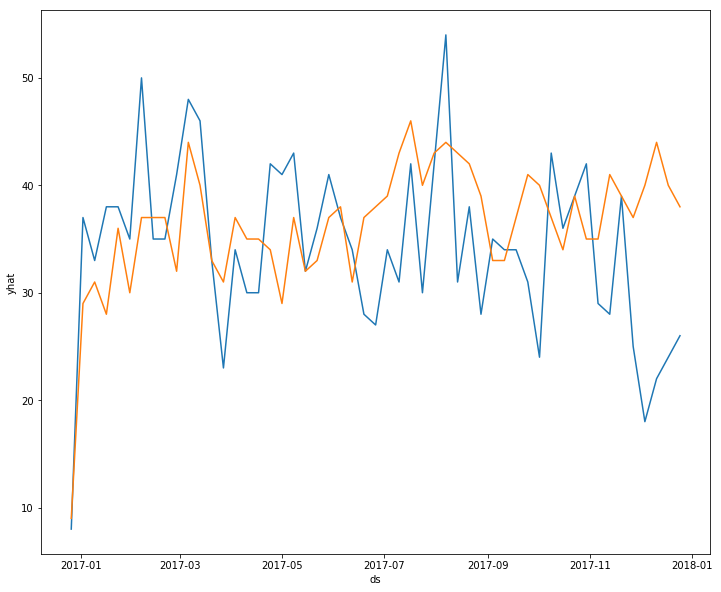

In [530]:
var = ('Mt St Joseph', 'DC1000', 'URBAN HLTH, MH&SU')
plot_data = weekly2[var]

ax = plt.subplots(figsize=(12,10))
ax = sns.lineplot(data= plot_data, x="ds", y="y")
ax = sns.lineplot(data= plot_data, x="ds", y="yhat")

In [531]:
for i in weekly2:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly2[i]["y"], weekly2[i]["yhat"]), 
                                         mae(weekly2[i]["y"], weekly2[i]["yhat"])))

("St Paul's Hospital", 'DC1000', 'RENAL'): MAPE: 6.168721907465779, MAE: 15.50943396226415
("St Paul's Hospital", 'DC1000', 'SURGERY'): MAPE: 8.097769942458493, MAE: 32.18867924528302
("St Paul's Hospital", 'DC1000', 'SENIORS CARE'): MAPE: nan, MAE: 0.0
("St Paul's Hospital", 'DC1000', 'HEART  LUNG'): MAPE: 8.140051166193622, MAE: 30.07547169811321
("St Paul's Hospital", 'DC1000', 'EMERG-ICU'): MAPE: 7.98428028911572, MAE: 23.09433962264151
("St Paul's Hospital", 'DC1000', 'MEDICINE'): MAPE: 8.394360592624752, MAE: 19.79245283018868
("St Paul's Hospital", 'DC1000', 'URBAN HLTH, MH&SU'): MAPE: 11.293692378382245, MAE: 28.830188679245282
("St Paul's Hospital", 'DC1000', 'PALLIATIVE SVCS'): MAPE: 28.71205388831794, MAE: 5.169811320754717
("St Paul's Hospital", 'DC1000', 'ACCESS SERVICES'): MAPE: 100.0, MAE: 0.11320754716981132
("St Paul's Hospital", 'DC1000', 'MATERNITY SERVICES'): MAPE: 14.789432160266744, MAE: 11.962264150943396
("St Paul's Hospital", 'DC1000', 'HUMAN RESOURCES'): MAPE:

In [532]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

St Paul's Hospital: MAPE: 4.066760414090086, MAE: 94.40384615384616
SVH Langara: MAPE: 19.278858889066335, MAE: 10.711538461538462
Mt St Joseph: MAPE: 10.514817350866284, MAE: 39.86538461538461
Brock Fahrni: MAPE: 21.579219916913612, MAE: 9.403846153846153
Holy Family: MAPE: 22.469615449026886, MAE: 17.76923076923077
Youville Residence: MAPE: 27.346761490659365, MAE: 13.615384615384615


In [533]:
# errors for each labor agreement
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

DC1000: MAPE: 4.4145366323430215, MAE: 116.42307692307692
DC2B00: MAPE: 19.286268323099094, MAE: 24.46153846153846
DC2A00: MAPE: 19.87457096669725, MAE: 31.153846153846153


In [534]:
# errors for each labor agreement
for i in small_programs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

RENAL: MAPE: 6.414217371919167, MAE: 18.365384615384617
SURGERY: MAPE: 6.487678641339764, MAE: 40.78846153846154
SENIORS CARE: MAPE: 15.81164352786693, MAE: 28.942307692307693
HEART  LUNG: MAPE: 6.961024147188691, MAE: 29.673076923076923
EMERG-ICU: MAPE: 5.770621006439423, MAE: 25.03846153846154
MEDICINE: MAPE: 8.314650265740696, MAE: 29.46153846153846
URBAN HLTH, MH&SU: MAPE: 12.269882561171439, MAE: 45.57692307692308
PALLIATIVE SVCS: MAPE: 26.353698778855367, MAE: 6.0
ACCESS SERVICES: MAPE: 23.710008151109616, MAE: 12.807692307692308
MATERNITY SERVICES: MAPE: 15.254579956214737, MAE: 13.98076923076923
HUMAN RESOURCES: MAPE: 56.15518736192784, MAE: 9.307692307692308
NURSING PRACTICE  EDU: MAPE: 268.5273043613488, MAE: 22.134615384615383
IMAGING: MAPE: 35.49140823955156, MAE: 7.403846153846154
INVALID: MAPE: nan, MAE: 0.0
NURSING ADMIN: MAPE: inf, MAE: 1.1730769230769231
WORKPL WS: MAPE: inf, MAE: 2.423076923076923
VP ADMIN SENIORS: MAPE: inf, MAE: 0.4230769230769231
PEOPLE STRATEGIES:

In [ ]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly2, method="mape"), 
                                             aggregate_error(weekly2, method="mae")))

# Minimize error

In [ ]:
for i in weekly2:
    forecasted = pred_results_past2[i]
    actual = split_data2[i]

    error = actual["y"] - forecasted["yhat"]
    obs = total_timeframe.copy()
    obs["error"] = error
    obs = obs.set_index("ds")

    decomp = decompose(obs, period=365)
    weekly_fcast = forecast(decomp, steps=365, fc_func=drift, seasonal=True)
    weekly_fcast["week"] = weekly_fcast.index-pd.DateOffset(weekday=0, weeks=1)
    weekly_fcast = weekly_fcast.groupby("week").sum()

    resid_fcast = weekly_fcast.reset_index()["drift+seasonal"]
    weekly_yhat = (weekly2[i]["yhat"] + resid_fcast).round(0)
    weekly_yhat_lower = (weekly2[i]["yhat_lower"] + resid_fcast).round(0)
    weekly_yhat_upper = (weekly2[i]["yhat_upper"] + resid_fcast).round(0)

    weekly2[i]["yhat"] = weekly_yhat.where(weekly_yhat >= 0, 0)
    weekly2[i]["yhat_lower"] = weekly_yhat_lower.where(weekly_yhat_lower >= 0, 0)
    weekly2[i]["yhat_upper"] = weekly_yhat_upper.where(weekly_yhat_upper >= 0, 0)

# Print new errors

In [ ]:
for i in weekly2:
    print("{}: MAPE: {}, MAE: {}".format(i, mape(weekly2[i]["y"], weekly2[i]["yhat"]), 
                                         mae(weekly2[i]["y"], weekly2[i]["yhat"])))

In [ ]:
# errors for each site
for i in small_sites:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

In [ ]:
# errors for each job family
for i in small_jfs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

In [ ]:
# errors for each job family
for i in small_programs:
    print("{}: MAPE: {}, MAE: {}".format(i, aggregate_error(weekly2, i, "mape"), aggregate_error(weekly2, i, "mae")))

In [ ]:
# total MAPE and MAE 
print("Total MAPE: {}\nTotal MAE: {}".format(aggregate_error(weekly2, method="mape"), 
                                             aggregate_error(weekly2, method="mae")))

### Run below code to export tables

In [63]:
# create data/predictions folder if it doesn't exist
predictions_path = "../data/predictions/"
if not os.path.exists(predictions_path):
    os.mkdir(predictions_path)


# export to "data/predictions/" directory
total_data = pd.DataFrame()
for i in weekly2:
    total_data = pd.concat([total_data, weekly2[i]], axis=0)
total_data.to_csv(predictions_path + "predictions_subprogram.csv")

# Save to pickle

In [527]:
import pickle

pickle_out = open("../data/predictions/program_models.pickle","wb")
pickle.dump(models2, pickle_out)
pickle_out.close()

# Load pickle

In [274]:
pickle_in = open("../data/predictions/subprogram_models.pickle","rb")
models2 = pickle.load(pickle_in)